In [1]:
import sys
import os
import csv
import pandas as pd
import html
import argparse
import codecs
import numpy as np
import random
import math as m
import itertools
import argparse
import re
import collections
from collections import OrderedDict
from collections import defaultdict
from itertools import chain
#import compute_rugosity as rug
from matplotlib.ticker import FormatStrFormatter
#from ccdc.descriptors import CrystalDescriptors,GeometricDescriptors, MolecularDescriptors
#from ccdc._lib import MathsLib
#from ccdc.io import EntryReader
#from ccdc.io import MoleculeReader
#from ccdc.io import CrystalReader
#from ccdc.io import CrystalWriter
import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
basedir = "C:/Users/wellawat/Downloads/GAL_structures"
rugosities = np.load(basedir+'/GAL_rugosity_shift_7.0.npy')

In [3]:
rug_dict = dict(((rugosities[i][0],float(rugosities[i][1])) for i in range(len(rugosities))))
rug_dict

{'FormII.cif': -0.1218568254414412,
 'FormIII.cif': -0.07055440192172827,
 'FormIV.cif': -0.20091387445433528,
 'FormIX.cif': -0.17739234823001787,
 'FormV.cif': -0.2337153288446676,
 'FormVI.cif': -0.15370910579663993,
 'FormVII.cif': -0.17343598304868305,
 'FormVIII.cif': -0.15138172497031302,
 'FormX.cif': -0.1070609337527576,
 'GM.cif': -0.22348957295894625}

In [4]:
rele_dict = {'FormII.cif': 14.259004,
 'FormIII.cif': 7.168103,
 'FormIV.cif':  3.758917,
 'FormIX.cif': 2.612444,
 'FormV.cif': 4.246201,
 'FormVI.cif': 5.446982,
 'FormVII.cif': 1.081492,
 'FormVIII.cif': 5.043976,
 'FormX.cif': 2.016176,
 'GM.cif': 0.00000}

### After getting SCF energies: create a dataframe

In [4]:
def create_init_df(scf_file,cols=['filename', 'energy']):
    data = pd.read_csv(scf_file, sep=' ', header=None, names=cols) 
    outname = scf_file.replace('.txt','.csv')
    nrows = data.shape[0]
    
    for i in range(nrows):
        fname = data['filename'][i].split('/')[-1]
        data['filename'][i] = fname.split('.')[0]

    data.to_csv(outname,index=False)
    return outname

In [5]:
outcsv = create_init_df(f'{basedir}/GAL_scf_done.txt',cols=['filename', 'energy'])
df = pd.read_csv(outcsv)
df.head()

,filename,energy
0,FormIII_m_1_gas_free,-1198.373545
1,FormIII_m_1_gas_restricted,-1198.369680
2,FormIII_m_1_water_free,-1198.409250
3,FormIII_m_1_water_restricted,-1198.407021
4,FormII_m_1_gas_free,-1198.368984


In [6]:
df

,filename,energy
0,FormIII_m_1_gas_free,-1198.373545
1,FormIII_m_1_gas_restricted,-1198.369680
2,FormIII_m_1_water_free,-1198.409250
3,FormIII_m_1_water_restricted,-1198.407021
4,FormII_m_1_gas_free,-1198.368984
5,FormII_m_1_gas_restricted,-1198.366935
6,FormII_m_1_water_free,-1198.405623
7,FormII_m_1_water_restricted,-1198.404414
8,FormIV_m_1_gas_free,-1198.368984
9,FormIV_m_1_gas_restricted,-1198.366339


### Find max energy component and keep it
 

In [9]:
gas_del_confE = defaultdict(list)
wat_del_confE = defaultdict(list)
file_names = list(df['filename'])

#gm_energy = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_free', 'energy'].iloc[0]
for file in file_names:
    splt = file.split('_')
    job = splt[-1]
    phase = splt[-2]
    key = file.split('_')[0]
    if job == 'free':
        if phase == 'gas':
            gm = 'GM_m_1_gas_free'
            conf_gm =  df.loc[df['filename'] == gm, 'energy'].iloc[0]
            conf_e2 =  df.loc[df['filename'] == file, 'energy'].iloc[0]
            delta_conf = (conf_e2-conf_gm)*2625.5
            gas_del_confE[key].append(delta_conf)

            
        else:
            gm = 'GM_m_1_water_free'
            conf_gm =  df.loc[df['filename'] == gm, 'energy'].iloc[0]
            conf_e2 =  df.loc[df['filename'] == file, 'energy'].iloc[0]
            delta_conf = (conf_e2-conf_gm)*2625.5
            wat_del_confE[key].append(delta_conf)
            

#keep the max E component            
gas_confE_final = {}
for k,v in gas_del_confE.items():
    gas_confE_final[k] = max(v)

    
wat_confE_final = {}
for k,v in wat_del_confE.items():
    wat_confE_final[k] = max(v)

In [17]:
def save_conf_df(conf_dict,rug_dict,rele_dict,phase):
    
    rugosities = []
    rel_free = []
    structures = list(conf_dict.keys())
    df1 = pd.DataFrame.from_dict(conf_dict, orient='index',columns=['Delta_conformational_energy(kJ/mol)'])
    df1.reset_index(inplace=True)
    df1 = df1.rename(columns = {'index':'Refcode'})
    
    for s in structures:
        cif_name = s+'.cif'
        rugosities.append(rug_dict[cif_name])
        rel_free.append(rele_dict[cif_name])
        
    df1['Rel_free_energy'] = rel_free
    df1['Rugosity']  = rugosities
    
    df1.to_csv(f'{basedir}/{phase}_coformational_energy.csv',index=False,header=True)

In [21]:
save_conf_df(gas_confE_final,rug_dict,rele_dict ,phase='Gas') 

In [22]:
save_conf_df(wat_confE_final,rug_dict,rele_dict ,phase='Water') 

## Compute Strain energies

In [23]:
gas_del_strainE = defaultdict(list)
wat_del_strainE = defaultdict(list)
file_names = list(df['filename'])


#gm_energy = df.loc[df['filename'] == f'XXIII-N70-qha_m_1_{phase}_free', 'energy'].iloc[0]
for file in file_names:
    splt = file.split('_')
    job = splt[-1]
    phase = splt[-2]
    key = splt[0]
    if job == 'free':
        fileR = file.replace('free','restricted')
        conf_e =  df.loc[df['filename'] == file, 'energy'].iloc[0]
        crys_e =  df.loc[df['filename'] == fileR, 'energy'].iloc[0]
        strain_e = (crys_e - conf_e)*2625.5
        
        ## GM strain'GM_m_1_gas_free'
        gm_xr  = df.loc[df['filename'] == f'GM_m_1_{phase}_free', 'energy'].iloc[0]
        gm_r  = df.loc[df['filename'] == f'GM_m_1_{phase}_restricted', 'energy'].iloc[0]
        gm_strain = (gm_r - gm_xr)*2625.5
        rel_strain = strain_e - gm_strain
        
        if phase == 'gas':    
            gas_del_strainE[key].append(rel_strain)
        else:
            wat_del_strainE[key].append(rel_strain)

delta_gas_strain_final = {}
for k,v in gas_del_strainE.items():
    delta_gas_strain_final[k] = max(v)
    
delta_wat_strain_final = {}
for k,v in wat_del_strainE.items():
    delta_wat_strain_final[k] = max(v)

In [25]:
def save_strain_df(strain_dict,rug_dict,rele_dict,phase):
    
    rugosities = []
    rel_free = []
    structures = list(strain_dict.keys())
    df1 = pd.DataFrame.from_dict(strain_dict, orient='index',columns=['Delta_strain_energy(kJ/mol)'])
    df1.reset_index(inplace=True)
    df1 = df1.rename(columns = {'index':'Refcode'})
    
    for s in structures:
        cif_name = s+'.cif'
        rugosities.append(rug_dict[cif_name])
        rel_free.append(rele_dict[cif_name])
        
    df1['Rel_free_energy'] = rel_free
    df1['Rugosity']  = rugosities
    
    df1.to_csv(f'{basedir}/{phase}_strain_energy.csv',index=False,header=True)

In [26]:
save_strain_df(delta_gas_strain_final,rug_dict,rele_dict ,phase='Gas') 

In [28]:
save_strain_df(delta_wat_strain_final ,rug_dict,rele_dict,phase='Water')

In [29]:
phases = ['Gas','Water']

for phase in phases:
    print(phase)
    df_c = pd.read_csv(f'{basedir}/{phase}_coformational_energy.csv')
    df_s = pd.read_csv(f'{basedir}/{phase}_strain_energy.csv')

    result = pd.concat([df_c, df_s], axis=1, join="inner")
    result = result.loc[:,~result.columns.duplicated()].copy()
    print(f'{basedir}/{phase}_all_energies.csv')
    result.to_csv(f'{basedir}/{phase}_all_energies.csv',index=False,header=True)

Gas
C:/Users/wellawat/Downloads/GAL_structures/Gas_all_energies.csv
Water
C:/Users/wellawat/Downloads/GAL_structures/Water_all_energies.csv


# Plot energies

In [ ]:
rugs = [float(r) for r in rugs]
rugs

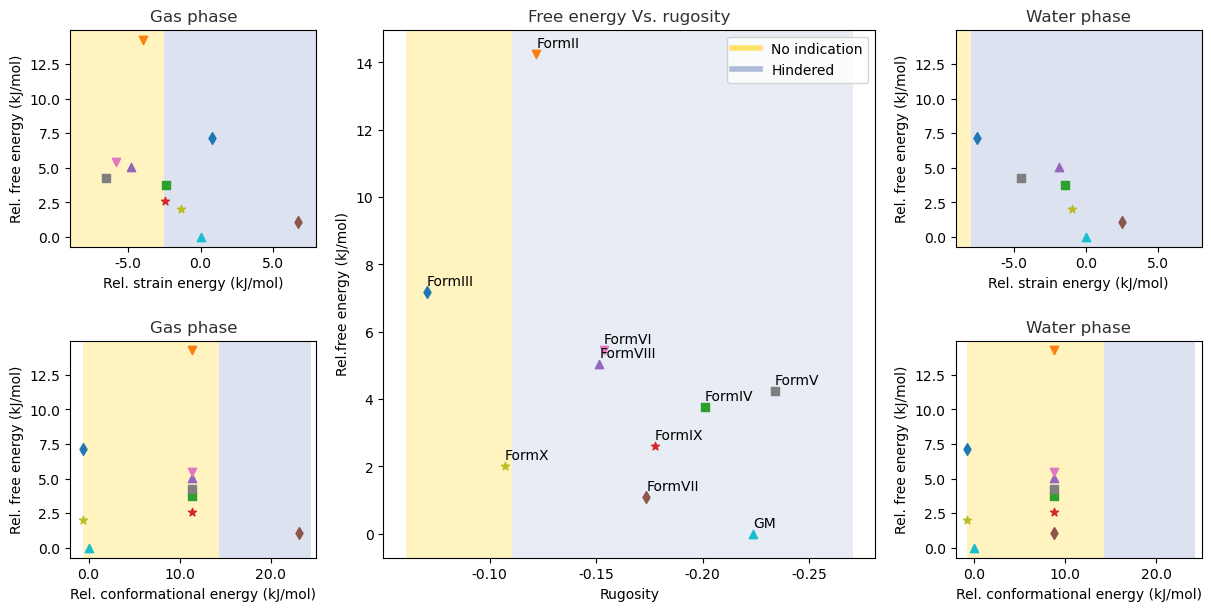

In [19]:
c_labels = ['D','E']
s_labels = ['A','C',]
solvents = ['Gas', 'Water']
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]

axd = plt.figure(figsize=(12,6),constrained_layout=True).subplot_mosaic(
    """
    ABC
    DBE
    """,
    gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1, 1],
        # set the width ratios between the columns
        "width_ratios": [1, 2, 1],
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

for i in range(2):
    phase = solvents[i]
    df = pd.read_csv(f'{phase}_all_energies.csv')
    free_e = list(df['Rel_free_energy'])
    strain_e = list(df['Delta_strain_energy(kJ/mol)'])
    conf_e = list(df['Delta_conformational_energy(kJ/mol)'])
    rugosity = list(df['Rugosity'])
    refs = list(df['Refcode'])
    title = f'{phase} phase'
    #gm_conf = df.loc[df['Refcode'] == 'GM', 'Delta_conformational_energy(kJ/mol)'].iloc[0]
    #gm_strain = df.loc[df['Refcode'] == 'GM', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    #gm_rug =  df.loc[df['Refcode'] == 'GM', 'Rugosity'].iloc[0]
    #gm_free = df.loc[df['Refcode'] == 'GM', 'Rel_free_energy'].iloc[0]
    #fV_conf = df.loc[df['Refcode'] == 'FormV', 'Delta_conformational_energy(kJ/mol)'].iloc[0] 
    #fV_strain = df.loc[df['Refcode'] == 'FormV', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    #fV_rug =  df.loc[df['Refcode'] == 'FormV', 'Rugosity'].iloc[0]
    #fV_free = df.loc[df['Refcode'] == 'FormV', 'Rel_free_energy'].iloc[0]

    for xs, ys, ms in zip(strain_e,free_e,markers):
        axd[s_labels[i]].scatter(xs, ys, marker=ms)#,s=50)
        
    for xc, yc, mc in zip(conf_e,free_e,markers):
        axd[c_labels[i]].scatter(xc, yc, marker=mc)#,s=50)
   
    #axd[c_labels[i]].scatter(gm_conf, gm_free, marker='s',s=100,c="#5adeed")
    #axd[s_labels[i]].scatter(gm_strain, gm_free, marker='s',s=100,c='#5adeed')
    #axd[c_labels[i]].scatter(fV_conf,fV_free, s=200, marker='s', edgecolor="#877b68", linewidth=2, facecolor='none')
    #axd[s_labels[i]].scatter(fV_strain,fV_free, s=200, marker='s', edgecolor="#877b68", linewidth=2, facecolor='none')
    axd[c_labels[i]].set_title(title,c='#2e3036')
    axd[s_labels[i]].set_title(title,c='#2e3036')
    axd[s_labels[i]].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axd[c_labels[i]].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axd[s_labels[i]].set_xlim(-9,8)
    axd[c_labels[i]].set_xlim(-2,25)
    axd[c_labels[i]].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axd[c_labels[i]].set_xlabel('Rel. conformational energy (kJ/mol)')
    axd[c_labels[i]].set_ylabel('Rel. free energy (kJ/mol)')
    axd[s_labels[i]].set_xlabel('Rel. strain energy (kJ/mol)')
    axd[s_labels[i]].set_ylabel('Rel. free energy (kJ/mol)')
    
    min_strain = min(list(df['Delta_strain_energy(kJ/mol)']))
    min_conf = min(list(df['Delta_conformational_energy(kJ/mol)']))
    max_strain = max(list(df['Delta_strain_energy(kJ/mol)']))
    max_conf = max(list(df['Delta_conformational_energy(kJ/mol)']))
    
    axd[s_labels[i]].axvspan(-9., min_strain+4.0, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    axd[c_labels[i]].axvspan(min_conf, min_conf+15, facecolor='#ffd92f',alpha=0.3,zorder=-1)
    axd[c_labels[i]].axvspan(min_conf+15, min_conf+25,facecolor='#8da0cb',alpha=0.3,zorder=-1)
    axd[s_labels[i]].axvspan(min_strain+4.0, 9, facecolor='#8da0cb',alpha=0.3,zorder=-1)
    

    '''axd[s_labels[i]].annotate("GM",
                xy=(strain_e[-1], free_e[-1]), xycoords='data',
                xytext=(strain_e[-1]-0.7,free_e[-1]+2), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    axd[c_labels[i]].annotate("GM",
                xy=(conf_e[-1], free_e[-1]), xycoords='data',
                xytext=(conf_e[-1]-0.1,free_e[-1]+2), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))

    axd[s_labels[i]].annotate("FormV",
                xy=(fV_strain, fV_free), xycoords='data',
                xytext=(fV_strain-0.6,fV_free+2), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    axd[c_labels[i]].annotate("FormV",
                xy=(fV_conf, fV_free), xycoords='data',
                xytext=(fV_conf-0.1,fV_free+2), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))'''
    
    
#axd['D'].axvspan(min_conf+15,25.0, facecolor='#8da0cb',alpha=0.3,zorder=-1)
axd['B'].set_title('Free energy Vs. rugosity', c='#2e3036')
for i in range(len(rugosity)):
    axd['B'].scatter(rugosity[i], free_e[i], marker=markers[i])#,s=50)
    axd['B'].annotate(refs[i], (rugosity[i], free_e[i] + 0.2))

#axd['B'].scatter(gm_rug, gm_free, marker='s',s=100,c="#5adeed")
#axd['B'].scatter(fV_rug, fV_free,  s=200, marker='s', edgecolor="#877b68", linewidth=2, facecolor='none')
axd['B'].set_xlabel('Rugosity')
axd['B'].set_ylabel('Rel.free energy (kJ/mol)')
axd['B'].invert_xaxis()
axd['B'].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axd['B'].axvspan(max(rugosity), max(rugosity)-0.04, facecolor='#ffd92f',alpha=0.3,zorder=-1)
axd['B'].axvspan(max(rugosity), max(rugosity)+0.01, facecolor='#ffd92f',alpha=0.3,zorder=-1)
axd['B'].axvspan(max(rugosity)-0.04, max(rugosity)-0.2, facecolor='#8da0cb',alpha=0.2,zorder=-1)
'''axd['B'].annotate("GM",
                xy=(rugosity[-1], free_e[-1]), xycoords='data',
                xytext=(rugosity[-1],free_e[-1]+1), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))

axd['B'].annotate("FormV",
                xy=(fV_rug, fV_free), xycoords='data',
                xytext=(fV_rug,fV_free+1), textcoords='data',

                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))'''
#axd['B'].axvspan(max(rugs)-0.2, min(rugs), facecolor='#f02424',alpha=0.2,zorder=-1)
#
custom_lines = [Line2D([0], [0], color='#ffd92f', alpha =0.7,lw=4),
                Line2D([0], [0], color='#8da0cb',alpha =0.7, lw=4)]
axd['B'].legend(custom_lines, ['No indication', 'Hindered'],loc=1,facecolor='w')
plt.savefig(f'abstract_colorcoded_GAL.png', dpi=300, facecolor='w')
plt.show()

## Color map

In [6]:
## color by energy value
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

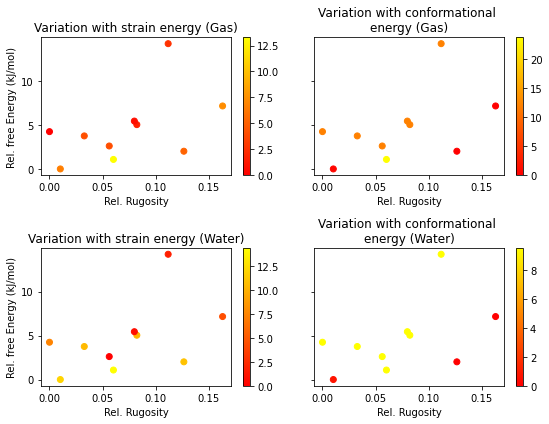

In [11]:
c_labels = ['D','E']
s_labels = ['A','C',]
solvents = ['Gas', 'Water']
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]

new_o = ListedColormap(cm.get_cmap('Oranges')(np.linspace(0.3,1, 20)))
new_b = ListedColormap(cm.get_cmap('Blues')(np.linspace(0.3,1, 20)))
cmp = ListedColormap(cm.get_cmap('RdYlBu')(np.linspace(0.3,1, 20)))
fig, axes = plt.subplots(2, 2,figsize=(8,6),sharey = True)
ax = axes.ravel()
for i in range(4):
    row = i//2
    phase = solvents[row]
    df = pd.read_csv(f'{basedir}/{phase}_all_energies.csv')
    
    free_e = list(df['Rel_free_energy'])
    norm_free = np.array(free_e) - min(free_e)
    strain_e = list(df['Delta_strain_energy(kJ/mol)'])
    norm_s = np.array(strain_e) - min(strain_e)
    conf_e = list(df['Delta_conformational_energy(kJ/mol)'])
    norm_c = np.array(conf_e) - min(conf_e)
    rugosity = list(df['Rugosity'])
    norm_rugs = np.array(rugosity) - min(rugosity)
    title = f'{phase} phase'
    gm_conf = df.loc[df['Refcode'] == 'GM', 'Delta_conformational_energy(kJ/mol)'].iloc[0]
    gm_strain = df.loc[df['Refcode'] == 'GM', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    gm_rug =  df.loc[df['Refcode'] == 'GM', 'Rugosity'].iloc[0]
    gm_free = df.loc[df['Refcode'] == 'GM', 'Rel_free_energy'].iloc[0]
    fV_conf = df.loc[df['Refcode'] == 'FormV', 'Delta_conformational_energy(kJ/mol)'].iloc[0] 
    fV_strain = df.loc[df['Refcode'] == 'FormV', 'Delta_strain_energy(kJ/mol)'].iloc[0]
    fV_rug =  df.loc[df['Refcode'] == 'FormV', 'Rugosity'].iloc[0]
    fV_free = df.loc[df['Refcode'] == 'FormV', 'Rel_free_energy'].iloc[0]
    
    ## create cmaps
    ax[i].annotate("GM",
        xy=(gm_rug, gm_free-min(free_e)), xycoords='data',
        xytext=(gm_rug,gm_free+1.0), textcoords='data',
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3"))
    
 
    if i%2 == 0:
        sc = ax[i].scatter(norm_rugs, norm_free, c=norm_s, cmap='autumn')
        ax[i].set_title(f'Variation with strain energy ({phase})')
        fig.colorbar(sc,ax=ax[i])
        ax[i].set_ylabel('Rel. free Energy (kJ/mol)')
    
    else:
        sc = ax[i].scatter(norm_rugs, norm_free, c=norm_c, cmap='autumn')
        ax[i].set_title(f'Variation with conformational \nenergy ({phase})')
        fig.colorbar(sc,ax=ax[i])
        
    ax[i].set_xlabel('Rel. Rugosity')
    
fig.tight_layout(w_pad=2.5)
fig.savefig(f'{basedir}/GAL_hue_energy_plot.png', dpi=300, facecolor='w')
fig.show()

-0.2337153288446676


In [19]:
df[df['Rugosity']==min(rugosity)]['Refcode'].values[0]

'FormV'

In [10]:
df

,Refcode,Delta_conformational_energy(kJ/mol),Rel_free_energy,Rugosity,Delta_strain_energy(kJ/mol)
0,FormIII,-0.722433,7.168103,-0.070554,-7.500948
1,FormII,8.799967,14.259004,-0.121857,-10.179746
2,FormIV,8.800020,3.758917,-0.200914,-1.433917
3,FormIX,8.799967,2.612444,-0.177392,-11.926675
4,FormVIII,8.799862,5.043976,-0.151382,-1.848089
5,FormVII,8.800046,1.081492,-0.173436,2.465266
6,FormVI,8.799783,5.446982,-0.153709,-11.168877
7,FormV,8.799836,4.246201,-0.233715,-4.503284
8,FormX,-0.723614,2.016176,-0.107061,-0.979863
9,GM,0.000000,0.000000,-0.223490,0.000000
